# Homework 4: Euler-Lagrange Equations (Creating your own physics sim)

In this homework assignment, you will work on examples that give you the basics of how to create your own simulator to model most robotic systems using the Euler-Lagrange equations.

Below you are given the dynamics of a double pendulum (or a 2R robot arm) as shown in the figure below.  
<img src="./double_pend.png" width="420">

You will solve for the dynamics of the double pendulum system in three ways. 

1. Hand-written through the Euler-Lagrange equation
2. Numerically using geometry 
3. Numerically using Lie Groups 

Below are the constants for the double pendulum and helper functions for integration. Read them closely. 

Use $q=[\theta_1, \theta_2]^\top$ as your double pendulum configuration.

In [1]:
# Import packages 
try: 
    from jax import config
    config.update("jax_enable_x64", True)
    import meshcat
    import meshcat.geometry as geom
    import meshcat.transformations as tfm
    import numpy as onp
    import time
    import jax.numpy as np
    import jax
    from jax import jacfwd, hessian
    from jaxlie import SE2, SE3
    import matplotlib.pyplot as plt
    
    print('Import packages works! Great work following directions :D !')
except Exception as e:
    print('Something went wrong. The following error tells you what happened. Go through README.md again and see what went wrong')
    print(e)


# Constants
_l1 = 1.0
_l2 = 1.0 
_m1 = 1.0 
_m2 = 1.0
_g = 9.81

# Helper functions for integration 
def euler_step(f, x, dt):
    """
        Input:
            xdot = f(x) - function to be integrated, passed as f
            x - initial condition to the function 
            dt - time step 
        Output: 
            x[t+dt] 
    """
    xdot = x + dt * f(x)
    return xdot

def rk4_step(f, x, dt):
    """
        Input:
            xdot = f(x) - function to be integrated, passed as f
            x - initial condition to the function 
            dt - time step 
        Output: 
            x[t+dt] 
    """
    # one step of runge-kutta integration
    k1 = f(x)
    k2 = f(x + dt*k1/2)
    k3 = f(x + dt*k2/2)
    k4 = f(x + dt*k3)
    xdot = x + 1/6*(k1+2*k2+2*k3+k4)*dt
    return xdot 

Import packages works! Great work following directions :D !


## Q.1 Hand-written Equations of motion for the double pendulum

In this question, you will be tasked to write down the equations of motion for the double pendulum by hand. 

### Q1.a Analytically Derived E-L Equations of Motion

Write the analytical solution to the Euler-Lagrange equation using LaTex expression below or through hand-written upload. 

$$KE = \frac{1}{2}m_1(\dot{x}^2_1 + \dot{y}^2_1) + \frac{1}{2}m_2(\dot{x}^2_2 + \dot{y}^2_2)$$

The first part of this equation, $KE_1 = \frac{1}{2}m_1(\dot{x}^2_1 + \dot{y}^2_1)$ simplifies to the single pendulum equation $KE_1 = \frac{1}{2} \cdot m_1 \cdot l_1^2 \cdot \dot{\theta}_1^2$

The second part of the equation determines $KE_2$. This is unfortunately more complicated, so we'll need to start with $\frac{1}{2}m_2(\dot{x}^2_2 + \dot{y}^2_2)$. Focusing on the velocity portion of the equation $\dot{x}^2_2 + \dot{y}^2_2$, for a double pendulumn, this is
$$(l_1 \dot{\theta}_1 cos(\theta_1) + l_2  (\dot{\theta}_1 + \dot{\theta}_2) cos(\theta_1 + \theta_2))^2 + (l_1 \dot{\theta}_1 sin(\theta_1) + l_2  (\dot{\theta}_1 + \dot{\theta}_2) sin(\theta_1 + \theta_2))^2$$

$$ = l_1^2 \dot{\theta}_1^2 cos(\theta_1)^2 + l_2^2 (\dot{\theta}_1 + \dot{\theta}_2)^2 cos(\theta_1 + \theta_2)^2 + 2 l_1 \dot{\theta}_1 cos(\theta_1) l_2  (\dot{\theta}_1 + \dot{\theta}_1^2) cos(\theta_1 + \theta_2) + l_1^2 \dot{\theta}_1^2 sin(\theta_1)^2 + l_2^2 (\dot{\theta}_1 + \dot{\theta}_2)^2 sin(\theta_1 + \theta_2)^2 + 2 l_1 \dot{\theta}_1 sin(\theta_1) l_2  (\dot{\theta}_1 + \dot{\theta}_1^2) sin(\theta_1 + \theta_2)$$

$$ = l_1^2 \dot{\theta}_1^2 cos(\theta_1)^2 + l_1^2 \dot{\theta}_1^2 sin(\theta_1)^2 + l_2^2 (\dot{\theta}_1 + \dot{\theta}_2)^2 cos(\theta_1 + \theta_2)^2 + l_2^2 (\dot{\theta}_1 + \dot{\theta}_2)^2 sin(\theta_1 + \theta_2)^2 +  2 l_1 \dot{\theta}_1 cos(\theta_1) l_2  (\dot{\theta}_1 + \dot{\theta}_1^2) cos(\theta_1 + \theta_2) + 2 l_1 \dot{\theta}_1 sin(\theta_1) l_2  (\dot{\theta}_1 + \dot{\theta}_1^2) sin(\theta_1 + \theta_2)$$

$$ = l_1^2 \dot{\theta}_1^2(cos(\theta_1)^2 + sin(\theta_1)^2) + l_2^2 (\dot{\theta}_1 + \dot{\theta}_2)^2 (cos(\theta_1 + \theta_2)^2 + sin(\theta_1 + \theta_2)^2) + 2 l_1 \dot{\theta}_1 cos(\theta_1) l_2  (\dot{\theta}_1 + \dot{\theta}_2)^2 cos(\theta_1 + \theta_2) + 2 l_1 \dot{\theta}_1 sin(\theta_1) l_2  (\dot{\theta}_1 + \dot{\theta}_2)^2 sin(\theta_1 + \theta_2)$$

$$ = l_1^2 \dot{\theta}_1^2 + l_2^2 (\dot{\theta}_1 + \dot{\theta}_2)^2 + 2 l_1 \dot{\theta}_1 cos(\theta_1) l_2  (\dot{\theta}_1 + \dot{\theta}_2)^2 cos(\theta_1 + \theta_2) + 2 l_1 \dot{\theta}_1 sin(\theta_1) l_2  (\dot{\theta}_1 + \dot{\theta}_2)^2 sin(\theta_1 + \theta_2)$$

$$ = l_1^2 \dot{\theta}_1^2 + l_2^2 (\dot{\theta}_1 + \dot{\theta}_2)^2 + 2 l_1 \dot{\theta}_1 l_2 (\dot{\theta}_1 + \dot{\theta}_2)^2 cos(\theta_1) cos(\theta_1 + \theta_2) + 2 l_1 \dot{\theta}_1 l_2 (\dot{\theta}_1 + \dot{\theta}_2)^2 sin(\theta_1) sin(\theta_1 + \theta_2)$$

$$ = l_1^2 \dot{\theta}_1^2 + l_2^2 (\dot{\theta}_1 + \dot{\theta}_2)^2 + 2 l_1 \dot{\theta}_1 l_2 (\dot{\theta}_1 + \dot{\theta}_2)^2(cos(\theta_1) cos(\theta_1 + \theta_2) + sin(\theta_1) sin(\theta_1 + \theta_2))$$

$$ = l_1^2 \dot{\theta}_1^2 + l_2^2 (\dot{\theta}_1 + \dot{\theta}_2)^2 + 2 l_1 \dot{\theta}_1 l_2 (\dot{\theta}_1 + \dot{\theta}_2)^2cos(\theta_2)$$

Accordingly, $KE_2 = \frac{1}{2} m_2(l_1^2 \dot{\theta}_1^2 + l_2^2 (\dot{\theta}_1 + \dot{\theta}_2)^2 + 2 l_1 \dot{\theta}_1 l_2 (\dot{\theta}_1 + \dot{\theta}_2)^2cos(\theta_2))$

$$KE = \frac{1}{2} \cdot m_1 \cdot l_1^2 \cdot \dot{\theta}_1^2 + \frac{1}{2} m_2(l_1^2 \dot{\theta}_1^2 + l_2^2 (\dot{\theta}_1 + \dot{\theta}_2)^2 + 2 l_1 \dot{\theta}_1 l_2 (\dot{\theta}_1 + \dot{\theta}_2)^2 cos(\theta_2))$$

---

$$PE = m_1 \cdot g \cdot y_1 + m_2 \cdot g \cdot y_2$$

Given the above image, $y_1$ can be computed based on trig, using $\text{cos}(\theta_1) = \frac{y_1}{-l_1}$, $y_1 = -l_1 \cdot \text{cos}(\theta_1)$.

To find $y_2$, we first need to find $y_2$ relative to $m_1$. The angle in this frame is $\theta_1 + \theta_2$ as the angles add together. This can be computed based on trig, using $\text{cos}(\theta_1 + \theta_2) = \frac{y_2}{-l_2}$, $y_2 = -l_2 \cdot \text{cos}(\theta_1 + \theta_2)$. We can get the global y position by adding $y_1$ to this. So, the full equation for $y_2$ is $y_2 = -l_2 \cdot \text{cos}(\theta_1 + \theta_2) + -l_1 \cdot \text{cos}(\theta_1)$. So
$$PE = m_1 \cdot g \cdot (-l_1 \cdot \text{cos}(\theta_1)) + m_2 \cdot g \cdot (-l_2 \cdot \text{cos}(\theta_1 + \theta_2) + l_1 \cdot \text{cos}(\theta_1))$$

---

$$L = KE - V$$

$$L = \frac{1}{2} \cdot m_1 \cdot l_1^2 \cdot \dot{\theta}_1^2 + \frac{1}{2} m_2(l_1^2 \dot{\theta}_1^2 + l_2^2 (\dot{\theta}_1 + \dot{\theta}_2)^2 + 2 l_1 \dot{\theta}_1 l_2 (\dot{\theta}_1 + \dot{\theta}_2)^2 cos(\theta_2)) - (m_1 \cdot g \cdot (-l_1 \cdot \text{cos}(\theta_1)) + m_2 \cdot g \cdot (-l_2 \cdot \text{cos}(\theta_1 + \theta_2) + l_1 \cdot \text{cos}(\theta_1)))$$

$$L = \frac{1}{2} \cdot m_1 \cdot l_1^2 \cdot \dot{\theta}_1^2 + \frac{1}{2} m_2(l_1^2 \dot{\theta}_1^2 + l_2^2 (\dot{\theta}_1 + \dot{\theta}_2)^2 + 2 l_1 \dot{\theta}_1 l_2 (\dot{\theta}_1 + \dot{\theta}_2)^2 cos(\theta_2)) - m_1 \cdot g \cdot (-l_1 \cdot \text{cos}(\theta_1)) - (m_2 \cdot g \cdot (-l_2 \cdot \text{cos}(\theta_1 + \theta_2) + l_1 \cdot \text{cos}(\theta_1)))$$


$$\frac{d}{dt} \frac{\partial L}{\partial \dot{q}} - \frac{\partial L}{\partial q} = 0$$


$$\frac{\partial KE}{\partial \theta_1} = 0$$

$$\frac{\partial PE}{\partial \theta_1} = m_1 \cdot g \cdot (-l_1 \cdot -\text{sin}(\theta_1)) + m_2 \cdot g \cdot (-l_2 \cdot -\text{sin}(\theta_1 + \theta_2) - l_1 \cdot -\text{sin}(\theta_1))$$

$$\frac{\partial PE}{\partial \theta_1} = m_1 \cdot g \cdot l_1 \cdot \text{sin}(\theta_1) + m_2 \cdot g \cdot (l_2 \cdot \text{sin}(\theta_1 + \theta_2) - l_1 \cdot \text{sin}(\theta_1))$$

$$\frac{\partial PE}{\partial \theta_1} = m_1 \cdot g \cdot l_1 \cdot \text{sin}(\theta_1) + m_2 \cdot g \cdot l_2 \cdot \text{sin}(\theta_1 + \theta_2) + m_2 \cdot g \cdot l_1 \cdot \text{sin}(\theta_1)$$

$$\frac{\partial PE}{\partial \theta_1} = m_1 \cdot g \cdot l_1 \cdot \text{sin}(\theta_1) + m_2 \cdot g \cdot l_1 \cdot \text{sin}(\theta_1) + m_2 \cdot g \cdot l_2 \cdot \text{sin}(\theta_1 + \theta_2)$$

$$\frac{\partial PE}{\partial \theta_1} = (m_1 + m_2) \cdot g \cdot l_1 \cdot \text{sin}(\theta_1) + m_2 \cdot g \cdot l_2 \cdot \text{sin}(\theta_1 + \theta_2)$$


$$\frac{\partial PE}{\partial \theta_2} = m_2 \cdot g \cdot l_2 \cdot \text{sin}(\theta_1 + \theta_2)$$

$$\frac{\partial KE}{\partial \theta_2} = -m_2 l_1 \dot{\theta}_1 l_2 (\dot{\theta}_1 + \dot{\theta}_2) sin(\theta_2)$$


$$\frac{\partial KE}{\partial \dot{\theta_1}} = m_1 \cdot l_1^2 \cdot \dot{\theta}_1 + \frac{1}{2} m_2(2 l_1^2 \dot{\theta}_1 + 2 l_2^2 (\dot{\theta}_1 + \dot{\theta}_2) +  l_1 l_2 (2 \dot{\theta}_1 + \dot{\theta}_2) cos(\theta_2))$$

$$\frac{\partial KE}{\partial \dot{\theta_1}} = m_1 \cdot l_1^2 \cdot \dot{\theta}_1 + m_2(l_1^2 \dot{\theta}_1 + l_2^2 (\dot{\theta}_1 + \dot{\theta}_2) + l_1 l_2 (2 \dot{\theta}_1 + \dot{\theta}_2) cos(\theta_2))$$

$$\frac{\partial KE}{\partial \dot{\theta_1}} = m_1 \cdot l_1^2 \cdot \dot{\theta}_1 + m_2 l_1^2 \dot{\theta}_1 + m_2 l_2^2 (\dot{\theta}_1 + \dot{\theta}_2) + l_1 l_2 m_2 (2 \dot{\theta}_1 + \dot{\theta}_2) cos(\theta_2)$$

$$\frac{\partial KE}{\partial \dot{\theta_1}} = (m_1 + m_2) l_1^2 \dot{\theta}_1 + m_2 l_2^2 (\dot{\theta}_1 + \dot{\theta}_2) + l_1 l_2 m_2 (2 \dot{\theta}_1 + \dot{\theta}_2) cos(\theta_2)$$


$$\frac{\partial KE}{\partial \dot{\theta_2}} = \frac{1}{2} m_2(2 l_2^2 (\dot{\theta}_1 + \dot{\theta}_2) + 2 l_1 \dot{\theta}_1 l_2 cos(\theta_2))$$

$$\frac{\partial KE}{\partial \dot{\theta_2}} = m_2 (l_2^2 (\dot{\theta}_1 + \dot{\theta}_2) + l_1 \dot{\theta}_1 l_2 cos(\theta_2))$$


$$\frac{d}{dt}\frac{\partial KE}{\partial \dot{\theta_1}} = (m_1 + m_2) l_1^2 \ddot{\theta}_1 + m_2 l_2^2 (\ddot{\theta}_1 + \ddot{\theta}_2) + l_1 l_2 m_2 (2 \ddot{\theta}_1 + \ddot{\theta}_2) cos(\theta_2) - l_1 l_2 m_2 (2 \dot{\theta}_1 + \dot{\theta}_2) sin(\theta_2)$$

$$\frac{d}{dt}\frac{\partial KE}{\partial \dot{\theta_2}} = m_2 (l_2^2 (\ddot{\theta}_1 + \ddot{\theta}_2) + l_1 \ddot{\theta}_1 l_2 cos(\theta_2) - l_1 \dot{\theta}_1 l_2 sin(\theta_2))$$

$$M(q) = \begin{bmatrix}
\frac{\partial KE}{\partial \dot{\theta_1}} & \frac{\partial KE}{\partial \dot{\theta_2}} \\
\frac{\partial KE}{\partial \dot{\theta_1}} & \frac{\partial PE}{\partial \theta_2}
\end{bmatrix}$$

$$M(q) = \begin{bmatrix}
(m_1 + m_2) l_1^2 + m_2 l_2^2 + 2 l_1 l_2 m_2 cos(\theta_2)    &    m_2 l_2^2 + l_1 l_2 m_2 cos(\theta_2) \\
m_2 l_2^2 + l_1 l_2 m_2 cos(\theta_2)    &     m_2 l^2_2
\end{bmatrix}$$

$$C(q, \dot{q}) = \begin{bmatrix}
\frac{\partial KE}{\partial \theta_1} & \frac{\partial KE}{\partial \dot{\theta_1}} \\
\frac{\partial KE}{\partial \dot{\theta_1}} & \frac{\partial KE}{\partial \theta_2}
\end{bmatrix}$$

$$C(q, \dot{q}) = \begin{bmatrix}
0 & -m_2 l_1 l_2 (2 \dot{\theta}_1 + \dot{\theta}_2) sin(\theta_2) \\
0 & -m_2 l_1 l_2 \dot{\theta}_1 sin(\theta_2)
\end{bmatrix}$$

$$V(q) = \begin{bmatrix}
-(\frac{\partial PE}{\partial \theta_1} + \frac{\partial KE}{\partial \theta_1}) \\
-(\frac{\partial PE}{\partial \theta_2} + \frac{\partial KE}{\partial \theta_2} )
\end{bmatrix}$$

$$V(q) = \begin{bmatrix}
-((m_1 + m_2) \cdot g \cdot l_1 \cdot \text{sin}(\theta_1) + m_2 \cdot g \cdot l_2 \cdot \text{sin}(\theta_1 + \theta_2) + 0) \\
-(m_2 \cdot g \cdot l_2 \cdot \text{sin}(\theta_1 + \theta_2) + m_2 l_1 \dot{\theta}_1 l_2 (\dot{\theta}_1 + \dot{\theta}_2) sin(\theta_2))
\end{bmatrix}$$

$$V(q) = -\frac{\partial L}{\partial q}$$


$$\ddot{q} = M(q)^{-1}(- C(q, \dot{q}) \dot{q} - V(q))$$

### Q1.b code in $\dot{x} = f(x)$ for the hand-written equations. Also code in the kinetic and potential energy, and the Lagrangian.

Make sure you use the constants defined above. 

In [2]:
def KE_handwritten(q,qdot):
    """
        Input: q, qdot, which are jax np.arrays
        Output: scalar kinetic energy
    """

    KE_1 = (0.5 * _m1 * (_l1 ** 2) * (qdot[0] ** 2))
    KE_2 = 0.5 * _m2 * ((_l1 ** 2) * (qdot[0] ** 2) + (_l2 ** 2) * ((qdot[0] + qdot[1]) ** 2) + 2 * _l1 * _l2 * qdot[0] * (qdot[0] + qdot[1]) * np.cos(q[1]))
    return KE_1 + KE_2

def PE_handwritten(q):
    """
        Input: q, which are jax np.arrays
        Output: scalar potential energy
    """
    y1 = _l1 * np.cos(q[0])
    y2 =  y1 + _l2 * np.cos(q[0] + q[1])
    return _m1 * _g * -y1 + _m2 * _g * -y2

def L_handwritten(q, qdot):
    """
        Input: q, qdot, which are jax np.arrays
        Output: scalar lagrangian energy
        Hint: use the prevously written equations to write down the Lagrangian
    """
    return KE_handwritten(q, qdot) - PE_handwritten(q)

def f_handwritten(x):
    """
        Input: 
            state = x = [q, qdot] -- the state of the system q, qdot stacked as an np.array
        Output: 
            xdot = [qdot, qddot] stacked as an np.array
    """
    q,qdot = np.split(x, 2)
    # ADD EQUIATIONS HERE
    # right
    
    Mq = np.array([
        [(_m1 + _m2) * _l1 ** 2 + _m2 * _l2 ** 2 + 2 * _l1 * _l2 * _m2 * np.cos(q[1]),  _m2 * _l2 ** 2 + _l1 * _l2 * _m2 * np.cos(q[1])],
        [_m2 * _l2 ** 2 + _l1 * _l2 * _m2 * np.cos(q[1]), _m2 * _l2 ** 2]
        ])

    Cq = np.array([
        [0,  -_m2 * _l1 * _l2 * (2 * qdot[0] + qdot[1]) * np.sin(q[1])],
        [0, -_m2 * _l1 * _l2 * qdot[0] * np.sin(q[1])]
        ])

    Vq = np.array([
        -((_m1 + _m2) * _g * _l1 * np.sin(q[0]) + _m2 * _g * _l2 * np.sin(q[0] + q[1])),
        -(_m2 * _g * _l2 * np.sin(q[0] + q[1]) + _m2 * _l1 * qdot[0] * _l2 * (qdot[0] + qdot[1]) * np.sin(q[1]))
    ])
    qddot = np.linalg.inv(Mq) @ (-Cq @ qdot + Vq)
    xdot = np.array([qdot,qddot]).reshape((4,))
    return xdot 

### Evaluate your expression below

Kinetic Energy:  0.2630066577841242 
 Potential Energy:  -28.89383268107706 
 Lagrangian:  29.156839338861186 
 f(x) :  [-0.2        -0.3         0.90429708 -4.69756843]


In [3]:
q_test = np.array([0.1,0.2])
qdot_test = np.array([-0.2, -0.3])
x_test = np.array([0.1,0.2, -0.2, -0.3])

print(
    'Kinetic Energy: ',KE_handwritten(q_test, qdot_test), '\n',
    'Potential Energy: ',PE_handwritten(q_test), '\n',
    'Lagrangian: ',L_handwritten(q_test, qdot_test), '\n',
    'f(x) : ', f_handwritten(x_test)
)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Kinetic Energy:  0.2630066577841242 
 Potential Energy:  -28.893832681077065 
 Lagrangian:  29.15683933886119 
 f(x) :  [-0.2        -0.3         0.90429708 -4.69756843]


## Q2. Geometrically constructed E-L Equation

Using the forward kinematics functions $p_k = f_k(q), v_k = J_k(q)\dot{q}$, where $J_k(q) = \frac{\partial f_k}{\partial q}$ is the Jacobian of each mass location, derive the Euler-Lagrange equations for the double pendulum.

### Q2.a Code up the forward kinematics and Jacobian from geometry for each center of mass.
 
Recall the Jacobian is given by the derivative of the forward kinematics with respect to the configuration. Use the `jacfwd` function to return the derivative of the forward kinematics. Hint: read the jax documentation for `jacfwd`, its input takes in a **function** and returns the derivative of the function with respect to the argument number, that is, `dfdx = jacfwd(f,argnums=1)` for `f(v,x)` and `x` is the argument at slot 1 (where v is at slot 0).

In [4]:
def p1(q):
    """
        Position of the first mass
        Input: 
            q - joints 
        Output: 
            x_1 - position of mass 1 
    """

    x1 = _l1 * np.sin(q[0])
    y1 = -_l1 * np.cos(q[0])
    return np.asarray([x1, y1])

def p2(q):
    """
        Position of the second mass
        Input: 
            q - joints 
        Output: 
            x_2 - position of mass 2
    """

    x1 = _l1 * np.sin(q[0])
    y1 = -_l1 * np.cos(q[0])

    x2 =  x1 + _l2 * np.sin(q[0] + q[1])
    y2 =  y1 + -_l2 * np.cos(q[0] + q[1])
    return np.asarray([x2,y2])

"""
    The function jacfwd is a wrapper around a function f and creates 
    a new function that outputs the derivative dfdx, with x as input.
    These functions compute the derivative of the mass location 
    with respect to the robot joint inputs q. Note this is 
    the jacobian J(q) = dfdq where v = J(q)qdot is velocity at the reference frame.  
"""
jac_p1 = jacfwd(p1)
jac_p2 = jacfwd(p2)

#### Evaluate your answer

FK Mass 1 : [ 0.09983342 -0.99500417] 
 FK Mass 2 : [ 0.39535362 -1.95034065] 
 Vel Mass 1 : [-0.19900083 -0.01996668] 
 Vel Mass 2 : [-0.67666908 -0.16772679]

In [5]:
q_test = np.array([0.1,0.2])
qdot_test = np.array([-0.2, -0.3])
print(
    'FK Mass 1 :', p1(q_test), '\n',
    'FK Mass 2 :', p2(q_test), '\n',
    'Vel Mass 1 :',jac_p1(q_test)@qdot_test, '\n',
    'Vel Mass 2 :',jac_p2(q_test)@qdot_test
)

FK Mass 1 : [ 0.09983342 -0.99500417] 
 FK Mass 2 : [ 0.39535362 -1.95034065] 
 Vel Mass 1 : [-0.19900083 -0.01996668] 
 Vel Mass 2 : [-0.67666908 -0.16772679]


### Q2.b Code up the kinetic and potential energies, Lagrangian, and the components of the manipulator equation using geometrically derived forward kinematics and Jacobians for each mass.

For the mass , coriolis, and gravity terms, you will need to use `hessian` and `jacfwd` functions consecutively with the `argnums` option to isolate the specific argument to take derivative w.r.t. 

Note: `hessian(f) = jacfwd(jacfwd(f))`

In [6]:
def KE_derived(q, qdot):
    v1 = jac_p1(q)@qdot
    v2 = jac_p2(q)@qdot
    m1 = np.array([[_m1, 0], [0, _m1]])
    m2 = np.array([[_m2, 0], [0, _m2]])

    return 1/2 * v1.T @ m1 @ v1 + 1/2 * v2.T @ m1 @ v2

def PE_derived(q):
    _, y1 = p1(q)
    _, y2 = p2(q)
    return _m1 * _g * y1 + _m2 * _g * y2

def L_derived(q, qdot):
    return KE_derived(q, qdot) - PE_derived(q)

M_derived = jacfwd(jacfwd(L_derived, argnums=1), argnums=1)
C_derived = jacfwd(jacfwd(L_derived, argnums=1), argnums=0)
G_derived = jacfwd(L_derived)

#### Evaluate your answer 
Kinetic Energy:  0.26300665778412413 
 Potential Energy:  -28.893832681077065 
 Lagrangian:  29.15683933886119 
 Mass Matrix:  [[4.96013316 1.98006658]
 [1.98006658 1.        ]] 
 Coriolis:  [-0.04172056 -0.01192016] 
 Gravity:  [-4.85778486 -2.91892016]

In [7]:
q_test = np.array([0.1,0.2])
qdot_test = np.array([-0.2, -0.3])
print(
    'Kinetic Energy: ',KE_derived(q_test, qdot_test), '\n',
    'Potential Energy: ',PE_derived(q_test), '\n',
    'Lagrangian: ',L_derived(q_test, qdot_test), '\n',
    'Mass Matrix: ',M_derived(q_test, qdot_test), '\n',
    'Coriolis: ',C_derived(q_test, qdot_test)@qdot_test, '\n',
    'Gravity: ',G_derived(q_test, qdot_test)
)

Kinetic Energy:  0.26300665778412424 
 Potential Energy:  -28.893832681077065 
 Lagrangian:  29.15683933886119 
 Mass Matrix:  [[4.96013316 1.98006658]
 [1.98006658 1.        ]] 
 Coriolis:  [-0.04172056 -0.01192016] 
 Gravity:  [-4.85778486 -2.91892016]


### Q2.d Code up the first-order dynamics modem $\dot{x} = f(x)$.

In [8]:
def f_derived(x):
    """
        Input: 
            state = x = [q, qdot] -- the state of the system 
        Output: 
            xdot = [qdot, qddot]
    """
    q,qdot = np.split(x, 2)
    # ADD CODE HERE
    qddot = -np.linalg.inv(M_derived(q, qdot)) @ (C_derived(q, qdot)@ qdot - G_derived(q, qdot))
    xdot = np.array([qdot,qddot]).reshape((4,))
    return xdot 

#### Evalaute your answer

Kinetic Energy:  0.2630066577841242 
 Potential Energy:  -28.89383268107706 
 Lagrangian:  29.156839338861186 
 f(x) :  [-0.2        -0.3         0.90429708 -4.69756843]


In [9]:
q_test = np.array([0.1,0.2])
qdot_test = np.array([-0.2, -0.3])
x_test = np.array([0.1,0.2, -0.2, -0.3])

print(
    'Kinetic Energy: ',KE_derived(q_test, qdot_test), '\n',
    'Potential Energy: ',PE_derived(q_test), '\n',
    'Lagrangian: ',L_derived(q_test, qdot_test), '\n',
    'f(x) : ', f_derived(x_test)
)

Kinetic Energy:  0.26300665778412424 
 Potential Energy:  -28.893832681077065 
 Lagrangian:  29.15683933886119 
 f(x) :  [-0.2        -0.3         0.90429708 -4.69756843]


## Q3 Euler-Lagrange Equations of Motion using Motion Group SE(2)

In this part of the homework you will recreate the equations of motion using Lie groups! 

### Q3.a Code up forward kinematics using SE(2) transforms
Use the jaxlie `SE2.from_xy_theta` function to create SE(2) transforms

In [10]:
def p1_lie(q):
    """
        Input: q, jax np.array
        Output: jaxlie SE2 transform
    """
    return SE2.from_xy_theta(0, 0, q[0]) @ SE2.from_xy_theta(0, -_l1, 0)

def p2_lie(q):
    """
        Input: q, jax np.array
        Output: jaxlie SE2 transform
    """
    return p1_lie(q) @ SE2.from_xy_theta(0, 0, q[1]) @ SE2.from_xy_theta(0, -_l2, 0)


#### Evaluate your answer

FK Mass 1 : [ 0.09983342 -0.99500417] 0.09999999999999999 
 FK Mass 2 : [ 0.39535362 -1.95034065] 0.3 

In [11]:
q_test = np.array([0.1,0.2])
qdot_test = np.array([-0.2, -0.3])
print(
    'FK Mass 1 :', p1_lie(q_test).translation(), p1_lie(q_test).rotation().as_radians(), '\n',
    'FK Mass 2 :', p2_lie(q_test).translation(), p2_lie(q_test).rotation().as_radians(), '\n',
)

FK Mass 1 : [ 0.09983342 -0.99500417] 0.09999999999999999 
 FK Mass 2 : [ 0.39535362 -1.95034065] 0.3 



### Q3.b Code up the body velocities for each mass using the Adjoint map
Recall that you would need to compute the body velocity $\xi_i(q, \dot{q})$ for all $i$ bodies. As a hint, start with writing down the time-derivative of the transform from world frame to the mass location as a function of joint configuration $q$. 

In [12]:
def vel_p1_lie(q, qdot):
    """
        Input: q , qdot, jax np.array
        Output: xi - body velocity at mass 1 location, jax np.array
    """
    return p1_lie(q).inverse().adjoint() @ np.array([0, 0, 1]) * qdot[0]

def vel_p2_lie(q, qdot):
    """
        Input: q , qdot, jax np.array
        Output: xi - body velocity at mass 2 location, jax np.array
    """
    return (SE2.from_xy_theta(0, -_l1, 0) @ SE2.from_xy_theta(0, 0, q[1]) @ SE2.from_xy_theta(0, -_l2, 0)).inverse().adjoint() @ np.array([0, 0, 1]) * qdot[0] + SE2.from_xy_theta(0, -_l2, 0).inverse().adjoint() @ np.array([0, 0, 1]) * qdot[1]
    

### Evaluate your answer
FK Mass 1 : [ 0.09983342 -0.99500417] 0.09999999999999999 
 FK Mass 2 : [ 0.39535362 -1.95034065] 0.3 
 xi 1 : [-0.2 -0.  -0.2] 
 xi_2 : [-0.69601332  0.03973387 -0.5       ]


In [13]:
q_test = np.array([0.1,0.2])
qdot_test = np.array([-0.2, -0.3])
print(
    'FK Mass 1 :', p1_lie(q_test).translation(), p1_lie(q_test).rotation().as_radians(), '\n',
    'FK Mass 2 :', p2_lie(q_test).translation(), p2_lie(q_test).rotation().as_radians(), '\n',
    'xi 1 :', vel_p1_lie(q_test, qdot_test),'\n',
    'xi_2 :', vel_p2_lie(q_test, qdot_test)
)

FK Mass 1 : [ 0.09983342 -0.99500417] 0.09999999999999999 
 FK Mass 2 : [ 0.39535362 -1.95034065] 0.3 
 xi 1 : [-0.2 -0.  -0.2] 
 xi_2 : [-0.69601332  0.03973387 -0.5       ]


### Q3.c Code up the Kinetic Energy, Potential energy, Lagrangian, and derive the components of the manipulator equation and dynamics $\dot{x} = f(x)$.
Use the forward kinematics and body velocity functions previously to construct the functions below.

In [14]:
def KE_lie(q, qdot):
    M1 = onp.diag([_m1,_m1,0.])
    M2 = onp.diag([_m2,_m2,0.])
    return 1/2 * vel_p1_lie(q, qdot).T @ M1 @ vel_p1_lie(q, qdot) + 1/2 * vel_p2_lie(q, qdot).T @ M2 @ vel_p2_lie(q, qdot)

def PE_lie(q):
    return _m1 * _g * (p1_lie(q).adjoint() @ np.array([0, 0, 1]))[0] + _m2 * _g * (p2_lie(q).adjoint() @ np.array([0, 0, 1]))[0]

def L_lie(q, qdot):
    return KE_lie(q, qdot) - PE_lie(q)

M_lie = jacfwd(jacfwd(L_lie, argnums=1), argnums=1)
C_lie = jacfwd(jacfwd(L_lie, argnums=1), argnums=0)
G_lie = jacfwd(L_lie)

def f_lie(x):
    """
        Input: 
            state = x = [q, qdot] -- the state of the system 
        Output: 
            xdot = [qdot, qddot]
    """
    q,qdot = np.split(x, 2)
    qddot = -np.linalg.inv(M_lie(q, qdot)) @ (C_lie(q, qdot)@ qdot - G_lie(q, qdot))
    xdot = np.array([qdot,qddot]).reshape((4,))
    return xdot 

### Evaluate your answer
Kinetic Energy:  0.26300665778412424 
 Potential Energy:  -28.893832681077065 
 Lagrangian:  29.15683933886119 
 Mass Matrix:  [[4.96013316 1.98006658]
 [1.98006658 1.        ]] 
 Coriolis:  [-0.04172056 -0.01192016] 
 Gravity:  [-4.85778486 -2.91892016] 
 f(x):  [-0.2        -0.3         0.90429708 -4.69756843]


In [15]:
q_test = np.array([0.1,0.2])
qdot_test = np.array([-0.2, -0.3])
x_test = np.hstack([q_test, qdot_test])
print(
    'Kinetic Energy: ',KE_lie(q_test, qdot_test), '\n',
    'Potential Energy: ',PE_lie(q_test), '\n',
    'Lagrangian: ',L_lie(q_test, qdot_test),'\n',
    'Mass Matrix: ',M_lie(q_test, qdot_test), '\n',
    'Coriolis: ',C_lie(q_test, qdot_test)@qdot_test, '\n',
    'Gravity: ',G_lie(q_test, qdot_test), '\n',
    'f(x): ', f_lie(x_test)
)

Kinetic Energy:  0.26300665778412424 
 Potential Energy:  -28.893832681077065 
 Lagrangian:  29.15683933886119 
 Mass Matrix:  [[4.96013316 1.98006658]
 [1.98006658 1.        ]] 
 Coriolis:  [-0.04172056 -0.01192016] 
 Gravity:  [-4.85778486 -2.91892016] 
 f(x):  [-0.2        -0.3         0.90429708 -4.69756843]


## Q4 Simulate the derived equations of motion of the pendulum


### Q4.a Create a function that takes in an initial condition $x_0$, integration time $t_f$, step-size $\Delta t$, dynamics function $f$, and integration method e.g., RK4 and returns a trajectory $x(t)$ for $t \in [0,t_f]$

Recall that the Euler and RK4 function only returns the subsequent step $t+\Delta t$ so you will need a for-loop. Store the recursive state values in a python list using the list member function `.append()`. Use the numpy function `stack` to create a matrix that stores the integrated trajectory $x(t)$ as a matrix array of size $N \times n$ where $N = \text{int}(\frac{t_f}{\Delta t})$ and $n = 2 n_q$, where $q, \dot{q} \in \mathbb{R}^{n_q}$.

In [16]:
def simulate(x0,tf,dt, f, integrator):
    # create the python list as
    trajectory = []
    # use the append member function to add the initial condition
    # the .copy prevents python from keeping around pointer references to the initial condition
    trajectory.append(x0.copy())
    ## ADD CODE HERE 
    for x in range(int(tf//dt)):
        trajectory.append(integrator(f, trajectory[-1], dt))

    return np.array(trajectory)

#### Evaluate the code
Make sure that your code runs appropriately without error. Output should be of right dimensions.

In [17]:
## initial conditions 
q0      = [0.6, 1.2]
qdot0   = [-1.6, 0.]
x0 = np.array(q0+qdot0)
tf = 4
dt = 0.005

print(
    simulate(x0.copy(), tf, dt, f_handwritten, euler_step).shape
)

(800, 4)


### Q4.b Plot the results below. 

All curves should be exactly the same using all calculated $f$ and integration method. To speed up our derived dynamics model we will be using the `jit` function that created compiled code. 
```
# this speeds up any derived functions using jax by compiling the function using jit
f_derived_jit = jax.jit(f_derived)
f_lie_jit     = jax.jit(f_lie)
```
The new functions `f_derived_jit` and `f_lie_jit` are then the compiled versions of the original functions you created which run much faster. Only use `jit` **after** you have confirmed your code works as intended with no bugs.  

Answer the following question. 
Why are the curves below different for the integration method? What is the trade-off for using one versus another? Type your answer below.

Euler integration and Runge-Kutta intergration use totally different methods to perform the integral. So, it's somewhat expected that for a complex integral like this, that they'd produce different answers. Euler Integration is simple to use an implement but is less likely to produce an accurate estimate as it approximated the integral using simple rectangles. Runge-Kutta Integration works well for ODEs and is more accurate than using Euler integration. Runge-Kutta uses 4 keypoints which can better approximate the intregral. So, as each method uses a different approach to approximate the intregral, it's expected that they give different results. Runge-Kutta is likely the more accurate estimate.

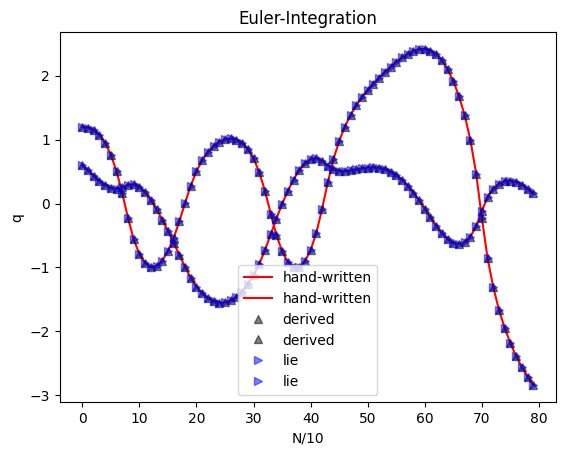

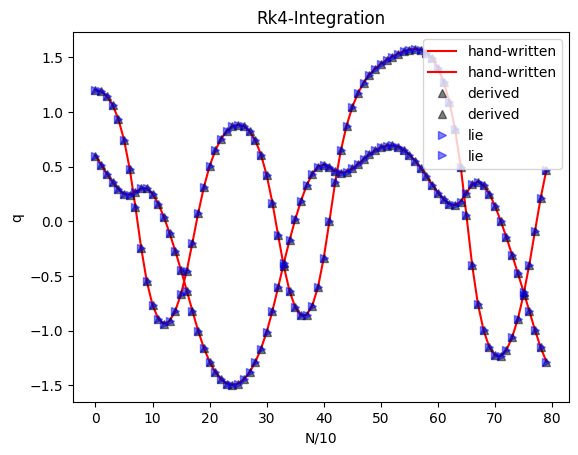

In [18]:
## initial conditions 
q0      = [0.6, 1.2]
qdot0   = [-1.6, 0.]
x0 = np.array(q0+qdot0)
tf = 4
dt = 0.005

# this speeds up any derived functions using jax by compiling the function using jit
f_derived_jit = jax.jit(f_derived)
f_lie_jit     = jax.jit(f_lie)

plt.figure(1)
plt.plot(simulate(x0.copy(), tf, dt, f_handwritten, euler_step)[::10,:2], 'r', label='hand-written')
plt.plot(simulate(x0.copy(), tf, dt, f_derived_jit, euler_step)[::10,:2], 'k^', alpha=0.5, label='derived')
plt.plot(simulate(x0.copy(), tf, dt, f_lie_jit, euler_step)[::10,:2], 'b>',alpha=0.5, label='lie')
plt.ylabel('q')
plt.xlabel('N/10')
plt.legend()
plt.title('Euler-Integration')

plt.figure(2)
plt.plot(simulate(x0.copy(), tf, dt, f_handwritten, rk4_step)[::10,:2], 'r', label='hand-written')
plt.plot(simulate(x0.copy(), tf, dt, f_derived_jit, rk4_step)[::10,:2], 'k^', alpha=0.5, label='derived')
plt.plot(simulate(x0.copy(), tf, dt, f_lie_jit, rk4_step)[::10,:2], 'b>',alpha=0.5, label='lie')
plt.ylabel('q')
plt.xlabel('N/10')
plt.legend()
plt.title('Rk4-Integration')

plt.show()

## Extra Credit: Animate the double-pendulum using meshcat

In [19]:

# Create a new visualizer
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7008/static/


In [20]:
vis.delete()
vis.jupyter_cell()

def build_leg(origin, parent_frame, num=0):
    joint_1 = parent_frame[f"joint_{num}_1"]
    joint_1["axis"].set_object(geom.triad())
    joint_1.set_transform(origin @ tfm.rotation_matrix(3 * np.pi/2 + .8, [1, 0, 0]))
    
    leg_1 = joint_1[f"leg_{num}_1"]
    leg_1["geom"].set_object(
        geom.Cylinder(1,0.05)
    )
    leg_1.set_transform(tfm.rotation_matrix(3 * np.pi/2, [1, 0, 0]) @ tfm.translation_matrix(np.array([0.,0.5,0.])))

    joint_2 = leg_1[f"joint_{num}_2"]
    joint_2["axis"].set_object(geom.triad())
    joint_2.set_transform(tfm.translation_matrix(np.array([0.,0.5,0])) @ tfm.rotation_matrix(np.pi/2 + 1.2, [1, 0, 0]))

    leg_2 = joint_2[f"leg_{num}_2"]
    leg_2["geom"].set_object(
        geom.Cylinder(1,0.05)
    )
    leg_2.set_transform(tfm.rotation_matrix(-np.pi/2, [1, 0, 0]) @ tfm.translation_matrix(np.array([0.,0.5,0])))
    return joint_1, joint_2

joint_1, joint_2 = build_leg(tfm.translation_matrix(np.array([0,0,0])), vis)

In [22]:
def set_leg_position(curr_joint_1, curr_joint_2, leg_1_offset, origin, leg_2_offset):
    curr_joint_1.set_transform(origin @ tfm.rotation_matrix(leg_1_offset, [1, 0, 0]))
    curr_joint_2.set_transform(tfm.translation_matrix(np.array([0.,0.5,0])) @ tfm.rotation_matrix(leg_2_offset, [1, 0, 0]))

DT = 0.001
TIME_LENGTH = 10
q0      = [0.6, 1.2]
qdot0   = [-1.6, 0.]
x0 = np.array(q0+qdot0)
set_leg_position(joint_1, joint_2, x0[0], tfm.translation_matrix(np.array([0,0,0])), x0[1])
steps = simulate(x0.copy(), TIME_LENGTH, DT, f_lie_jit, rk4_step)
for step in steps:
    set_leg_position(joint_1, joint_2, step[0], tfm.translation_matrix(np.array([0,0,0])), step[1])
    time.sleep(DT)